<a href="https://colab.research.google.com/github/overthemoon0/LLM-exam---Tensorflow-and-Distilbert/blob/main/%D0%A1%D0%BE%D0%B1%D0%B5%D1%81%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%2C_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача 5

Здесь представлены абсолютно реальные данные из Яндекс.Метрики с некоторыми добавлениями.  
"Target" содержит 1 или 0, где 1 - это конверсия, 0 - нет.  
"Bid" - ставка, которую банк был готов заплатить за клик по рекламе.  
"Расходы" - сколько реально было потрачено за этот клик.  

Колонка "Условие показа объявления" была закодирована:  
"Условие показа объявления hashed" - здесь хэши той же длины, что и реальное слово и, соответственно, имеют ту же частоту.  
"Условие показа объявления embedding" - эмбединги для условия показа объявления.  

Задача: Банку нужно максимизировать конверсии, но при этом не тратить слишком много денег. Конверсию хотелось бы получать не дороже 4000 рублей, а для лендинга action.norvikbank.ru/currency_exchange не дороже 500 рублей.

Размер файла ~250 Мб.

Для работы с parquet могут быть полезны:
pip install pyarrow

In [2]:
import pandas as pd
import pyarrow.parquet as pq
import requests
from io import BytesIO

# url адрес данных
url = "https://storage.yandexcloud.net/norvpublic/metric_for_interviews.parquet"

# Делаем HTTP запрос и сохраняем ответ
r = requests.get(url)
data = r.content
table = pq.read_table(BytesIO(data))

# Конвертируем Apache Arrow PyTable в Pandas DataFrame
df:pd.DataFrame = table.to_pandas()

In [3]:
pd.set_option('display.max_columns', 150)
df.head(2)

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed
0,2023-03-27 00:32:00+00:00,1492538189036126363,1679866369380985225,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_mob...,8,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.238.xxx,1,1,chromemobile,<NA>,43260174282,search,action.norvikbank.ru/credit_1,1,9:21,Яндекс,17.08,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb
1,2023-03-27 00:46:00+00:00,1492753384505344130,1679867202359463034,84460901,5148420803,additional,group_5148420803_banner_13648891761_device_mob...,15,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,motorola,android,mobile_Android,31.173.80.xxx,1,1,chromemobile,<NA>,43694449049,search,norvikbank.ru/lp/refinancing,1,9:21,Яндекс,NaN,NaN,0,"[-0.0059991320595145226, -0.014896205626428127...",37f936f1647bcb66 446f6f b76 4d3e3


## **EDA**

In [4]:
# BASE
import numpy as np

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIGURATIONS
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')
%matplotlib inline

# Import necessary libraries
import xgboost as xgb
import lightgbm as lgb

# sklearn
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.model_selection import *


In [5]:
df.shape

(32922, 32)

In [6]:
# Get the data types of all columns
dtypes = df.dtypes
# Count the number of categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category', 'string']).columns
print("Number of categorical columns:", len(categorical_cols))
# Print the number of categorical columns
numerical_cols = df.select_dtypes(include=['float', 'int', 'uint8', 'Int8']).columns
print("Number of numerical columns:", len(numerical_cols))

Number of categorical columns: 24
Number of numerical columns: 7


In [7]:
df.dtypes

дата визита с временем (мин)           datetime64[ns, Etc/UTC]
id визита                                               string
id клиента                                              string
Кампания Яндекс.Директа                                 string
Группа объявлений                                       string
Тип условия показа объявления                           string
utmcontent                                              string
время на сайте (сек)                                     int32
регион                                                  string
округ                                                   string
размер города                                           string
тип сети                                                string
рекламная система                                       string
марка телефона                                          string
операционная система                                    string
тип операционной системы                               

In [8]:
# описываем численные переменные
df.describe().T

,count,mean,std,min,25%,50%,75%,max
время на сайте (сек),32922.00,75.93,222.63,0.00,15.00,17.00,55.00,7119.00
ym_s_cookieenabled,32922.00,1.00,0.03,0.00,1.00,1.00,1.00,1.00
ym_s_javascriptenabled,32922.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
ym_s_isnewuser,32922.00,0.79,0.40,0.00,1.00,1.00,1.00,1.00
расходы,22696.00,394.51,820.18,0.00,0.00,64.05,369.94,13390.02
bid,20717.00,1257.29,1359.02,0.00,64.00,561.00,3000.00,6607.00
target,32922.00,0.04,0.20,0.00,0.00,0.00,0.00,1.00


In [9]:
# convert all string columns to object type
df = df.astype({col: 'object' for col in df.select_dtypes('string')})
df = df.astype({col: 'float' for col in df.select_dtypes(['float', 'int8', 'uint8', 'int32']) if col not in ['target', 'ym_s_isnewuser', 'ym_s_javascriptenabled']})
df['id визита'] = df['id визита'].astype('float') # конвертируем для проверки на предмет потенциального лика. Если лик не будет обнаружен, то колонку можно удалить.
df['id клиента'] = df['id клиента'].astype('float') # конвертируем для проверки на предмет потенциального лика. Если лик не будет обнаружен, то колонку можно удалить.

In [10]:
summary = df["target"].value_counts(normalize = True)
print(summary) # classes are unbalanced

0   0.96
1   0.04
Name: target, dtype: float64


<ipython-input-11-20b641fc8f2c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()
<ipython-input-11-20b641fc8f2c>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix_target = df.corr()['target'].sort_values(ascending=False)


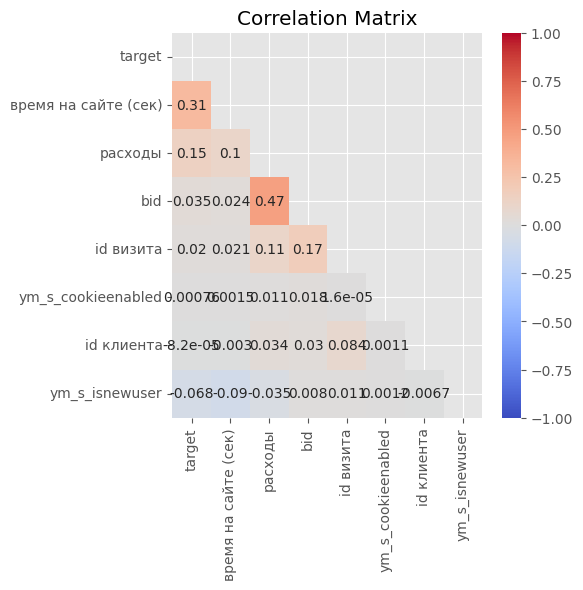

In [11]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Set the correlation threshold value
corr_threshold = 0.00

# Compute the correlation between each column and the target variable
corr_matrix_target = df.corr()['target'].sort_values(ascending=False)

# Select the top correlated columns that meet the threshold criteria
high_corr_columns = corr_matrix_target[abs(corr_matrix_target) > corr_threshold].index.tolist()

# Subset the original DataFrame to include only highly correlated columns with the target variable
df_high_corr = df[high_corr_columns]

# Compute the correlation matrix for the high correlated columns
high_corr_matrix = df_high_corr.corr()

# Create a mask for the lower triangle of the array
mask = np.zeros_like(high_corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Create the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Correlation Matrix')
plt.show()

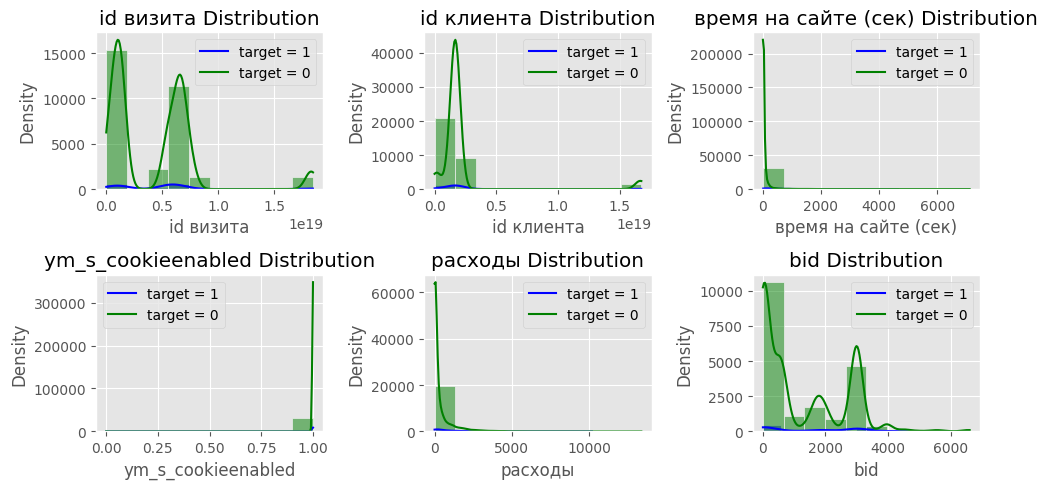

In [12]:
def compare_multifeature_target_distribution(dataframe, target_col, features, target_value1=1, target_value2=0, bins=10, grid_rows=12, grid_cols=6):
    """
    Plots the distribution of multiple features w.r.t. two different target values as a grid of plots.

    Parameters:
    dataframe (pandas DataFrame): A dataframe containing the features and target variable.
    target_col (str): Name of the target variable column.
    features (list of strings): Names of the feature columns.
    target_value1: First target variable value to compare.
    target_value2: Second target variable value to compare.
    bins (int): The number of bins to show in the histogram.
    grid_rows (int): The number of rows to use in the grid.
    grid_cols (int): The number of columns to use in the grid.

    Returns:
    None
    """

    fig, axs = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(10, 5))
    axs = axs.flatten()
    for i, feature in enumerate(features):
        target1_dist = dataframe[dataframe[target_col] == target_value1][feature]
        target2_dist = dataframe[dataframe[target_col] == target_value2][feature]
        sns.histplot(target1_dist, kde=True, bins=bins, color='blue', alpha=0.5, ax=axs[i])
        sns.histplot(target2_dist, kde=True, bins=bins, color='green', alpha=0.5, ax=axs[i])
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Density')
        axs[i].set_title(f'{feature} Distribution')
        axs[i].legend(labels=[f"{target_col} = {target_value1}", f"{target_col} = {target_value2}"])

    fig.tight_layout()
    plt.show()

compare_multifeature_target_distribution(df, 'target', df.select_dtypes(include=['float']).columns, grid_rows=2, grid_cols=3)

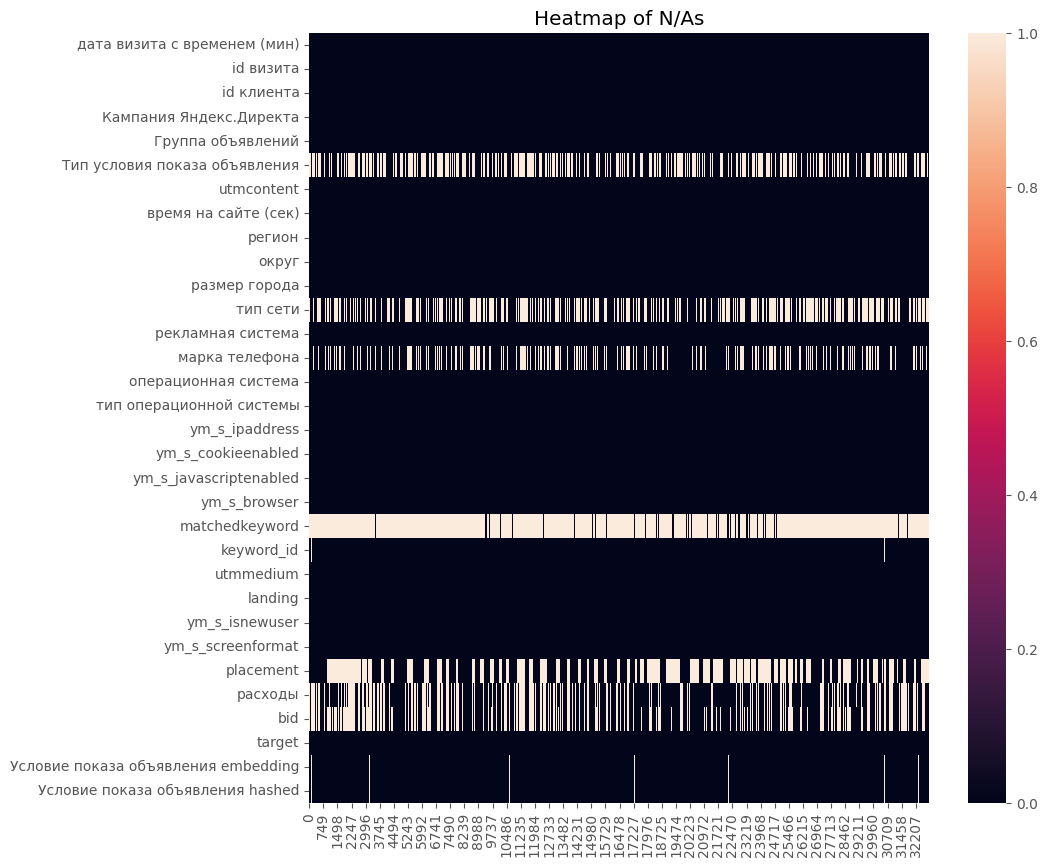

In [13]:
# generating heatmap of N/As
plt.style.use('ggplot')
plt.figure(figsize=(10,10))
sns.heatmap(df.isna().T)
plt.title('Heatmap of N/As')
plt.show()

In [14]:
print("amount of rows with missing values in the dataset:")
print(df.isna().any(axis=1).sum())
print("amount of cols with missing values in the dataset:")
print(df.isna().any(axis=0).sum())

amount of rows with missing values in the dataset:
32428
amount of cols with missing values in the dataset:
11


In [15]:
df.isna().sum().sort_values(ascending = False)

matchedkeyword                         30728
placement                              15591
тип сети                               15565
Тип условия показа объявления          14789
bid                                    12205
расходы                                10226
марка телефона                          9177
Условие показа объявления hashed         279
Условие показа объявления embedding      279
keyword_id                                79
размер города                             25
utmmedium                                  0
ym_s_isnewuser                             0
landing                                    0
ym_s_javascriptenabled                     0
ym_s_screenformat                          0
target                                     0
ym_s_browser                               0
дата визита с временем (мин)               0
ym_s_cookieenabled                         0
id визита                                  0
тип операционной системы                   0
операционн

In [16]:
matchedkeyword = df[df['matchedkeyword'].isna()]["target"].mean()
placement = df[df['placement'].isna()]["target"].mean()
nettype = df[df['тип сети'].isna()]["target"].mean()
conditiontype = df[df['Тип условия показа объявления'].isna()]["target"].mean()
print(matchedkeyword, placement, nettype, matchedkeyword) # валидируемся, что распределение таргета в фичах с большим количеством пропусков примерно соответствует.

0.04458474355636553 0.05022128150856263 0.04979119820109219 0.04458474355636553


In [17]:
unique_values = []
for col in df.columns:
    try:
        unique_vals = df[col].nunique()
        unique_values.append((unique_vals, col))
    except TypeError:
        unique_values.append((0, col))

for col in sorted(unique_values, reverse = True):
    if col[0] != 0:
        print(f"{col[1]}: {col[0]} unique values")
    else:
        print(f"{col[1]}: has unhashable data type")

id визита: 32922 unique values
дата визита с временем (мин): 29529 unique values
id клиента: 27005 unique values
utmcontent: 15708 unique values
расходы: 8167 unique values
ym_s_ipaddress: 7027 unique values
keyword_id: 5875 unique values
Группа объявлений: 2894 unique values
Условие показа объявления hashed: 1895 unique values
время на сайте (сек): 1181 unique values
bid: 475 unique values
matchedkeyword: 253 unique values
Кампания Яндекс.Директа: 150 unique values
ym_s_screenformat: 53 unique values
марка телефона: 52 unique values
регион: 36 unique values
ym_s_browser: 33 unique values
placement: 18 unique values
landing: 16 unique values
операционная система: 10 unique values
округ: 8 unique values
размер города: 7 unique values
тип сети: 5 unique values
тип операционной системы: 5 unique values
рекламная система: 2 unique values
Тип условия показа объявления: 2 unique values
ym_s_isnewuser: 2 unique values
ym_s_cookieenabled: 2 unique values
target: 2 unique values
ym_s_javascript

Фичи с одним уникальным значением ("utmmedium", "ym_s_javascriptenabled"), а также разряженные категориальные фичи с большим количеством пропусков ("matchedkeyword", "placement") мы удалим из датасета.
Также мы удалим ряды с отсутвтующими значениями в полях "Условие показа объявления hashed", "Условие показа объявления embedding", так как они отсутсвуют только в 1% датасета.

Колонки "расходы" и "bid" важны для решения поставленной задачи. Мы заполним в них пропуски с помощью алгоритма KNN.

In [18]:
df = df.dropna(subset=['Условие показа объявления embedding', 'Условие показа объявления hashed' , 'keyword_id', 'размер города'])

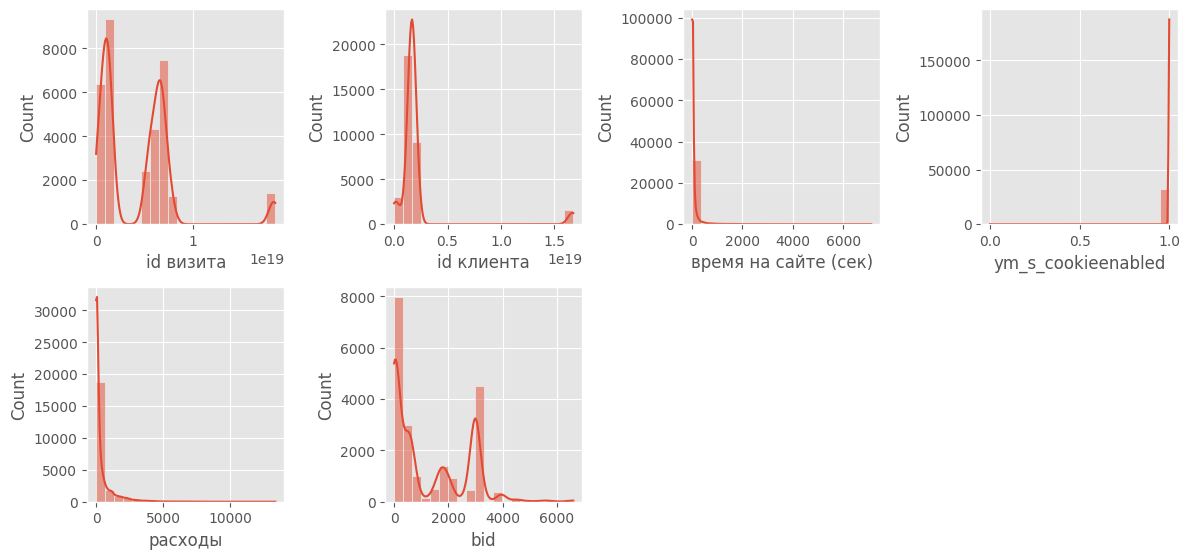

In [19]:
# Plot  features
fig=plt.figure(figsize=(12,8))
for i, var_name in enumerate(df.select_dtypes(include=['float', 'int']).columns):
    ax=fig.add_subplot(3,4,i+1)
    sns.histplot(data=df, x=var_name, bins=20, kde=True, alpha = 0.5)
plt.tight_layout()

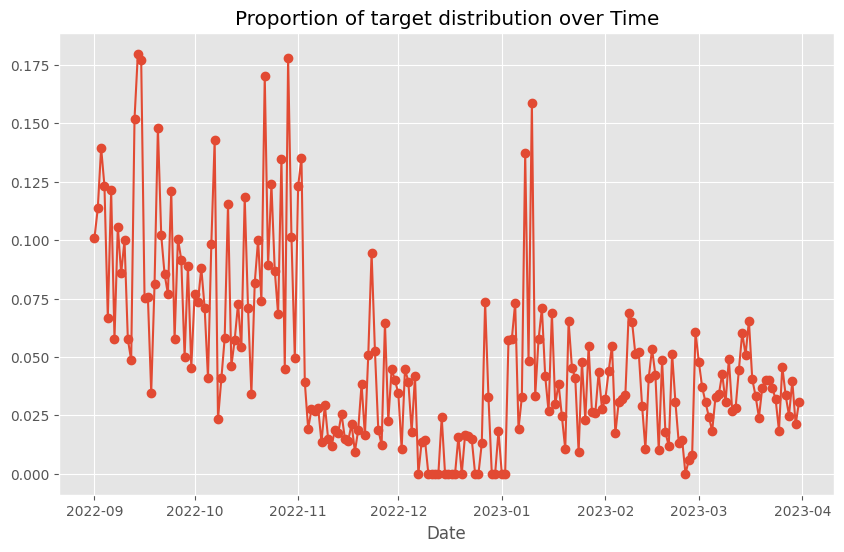

In [20]:
proportion_over_time = df.groupby(df['дата визита с временем (мин)'].dt.date)['target'].mean()
plt.figure(figsize=(10, 6))
plt.plot(proportion_over_time, marker='o', linestyle='-')
plt.xlabel('Date')
plt.title('Proportion of target distribution over Time')
plt.grid(True)
plt.show()

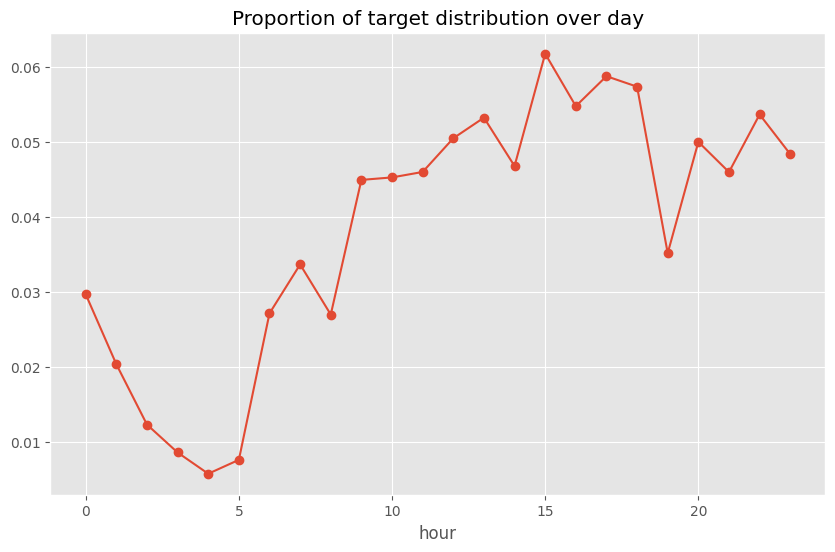

In [21]:
proportion_by_hour = df.groupby([df['дата визита с временем (мин)'].dt.hour])['target'].mean() # аггрегируемся по часам и пытаемся распознать, есть ли систематические всплески в определенные моменты в течение дня

plt.figure(figsize=(10, 6))
plt.plot(proportion_by_hour, marker='o', linestyle='-')
plt.xlabel('hour')
plt.title('Proportion of target distribution over day')
plt.grid(True)
plt.show()

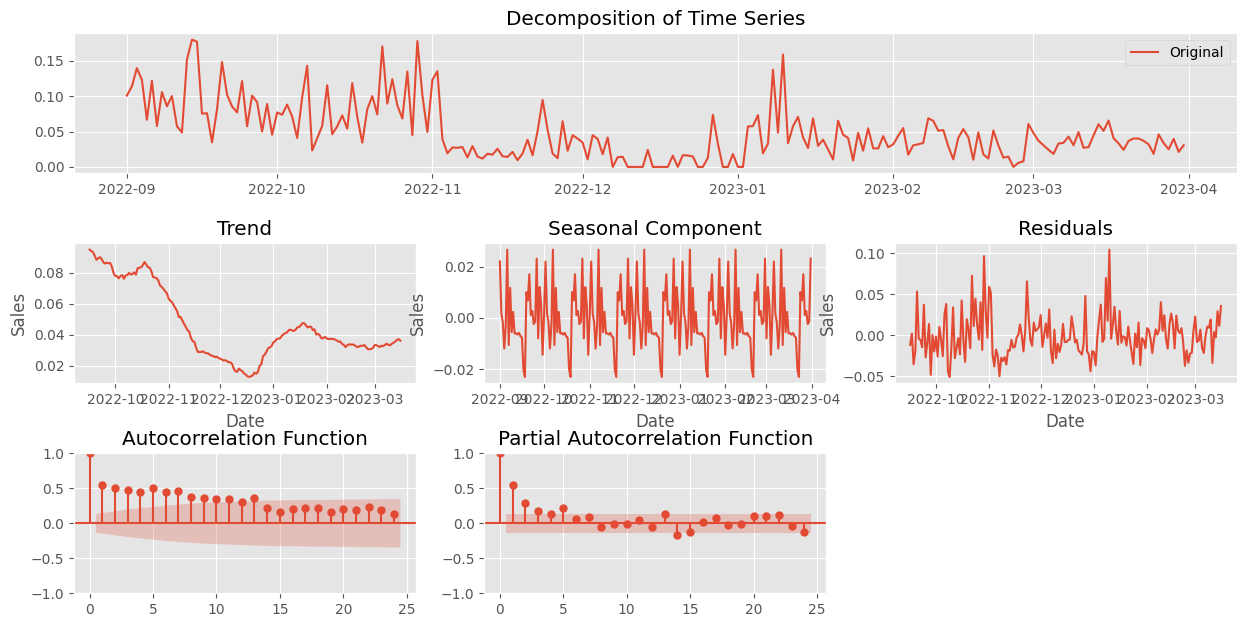

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Decompose the time series
decomposition = seasonal_decompose(proportion_over_time, model='additive', period=31)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


# create a grid of subplots using GridSpec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(4, 3, figure=fig)

# plot the original time series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(proportion_over_time)
ax1.set_title('Decomposition of Time Series')
ax1.legend(['Original'], loc='best')

# plot the trend component
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(trend)
ax2.set_title('Trend')
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')

# plot the seasonal component
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(seasonal)
ax3.set_title('Seasonal Component')
ax3.set_xlabel('Date')
ax3.set_ylabel('Sales')

# plot the residual component
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(residual)
ax4.set_title('Residuals')
ax4.set_xlabel('Date')
ax4.set_ylabel('Sales')

# plot the autocorrelation function
ax5 = fig.add_subplot(gs[2, 0])
plot_acf(proportion_over_time, ax=ax5)
ax5.set_title('Autocorrelation Function')

# plot the partial autocorrelation function
ax6 = fig.add_subplot(gs[2, 1])
plot_pacf(proportion_over_time, ax=ax6)
ax6.set_title('Partial Autocorrelation Function')

# hide the unused subplot
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

# add spacing between subplots
fig.subplots_adjust(hspace=0.5)

# show the plot
plt.show()


## Feature Engineering

In [23]:
# Add features to the training dataset
df = df.copy()
df['day_of_week'] = df['дата визита с временем (мин)'].dt.dayofweek
df['day'] = df['дата визита с временем (мин)'].dt.day
df['month'] = df['дата визита с временем (мин)'].dt.month
df['quarter'] = df['дата визита с временем (мин)'].dt.quarter
df['year'] = df['дата визита с временем (мин)'].dt.year
df['trend_slope'] = np.arange(len(df)) / len(df)
## we should use lag features with with caution because they can represent data leakage. Since we do not know the prediction interval we will not use them for now.

In [24]:
# create a new column 'расходы_true' with values of 1 for non-missing rows
df['расходы_true'] = df['расходы'].apply(lambda x: 1 if x is not None else 0)

# create a new column 'bid_true' with values of 1 for non-missing rows
df['bid_true'] = df['bid'].apply(lambda x: 1 if x is not None else 0)

# For now we create a new imputation object with 5 nearest neighbors. However it is essential to understand the nature of the missing values in these columns
imputer = KNNImputer(n_neighbors=5)

KNN_imputation = imputer.fit_transform(df[['расходы', 'bid']])
df[['расходы', 'bid']] = KNN_imputation

In [25]:
# create a new column 'good_conversion' with values of 1 for non-missing rows
df['good_conversion']=0
df.loc[(df['расходы']<=4000) & (df['landing'] != 'action.norvikbank.ru/currency_exchange'), 'good_conversion']=1
df.loc[(df['расходы']<=500) & (df['landing']  == 'action.norvikbank.ru/currency_exchange'), 'good_conversion']=1

In [26]:
df[['Тип условия показа объявления', 'тип сети', 'марка телефона']] = df[['Тип условия показа объявления', 'тип сети', 'марка телефона']].fillna('unknown')

In [27]:
df.head(2)

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,day_of_week,day,month,quarter,year,trend_slope,расходы_true,bid_true,good_conversion
0,2023-03-27 00:32:00+00:00,1492538189036126464.00,1679866369380985344.00,83101661,5130020019,unknown,group_5130020019_banner_13472642339_device_mob...,8.00,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),unknown,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.238.xxx,1.00,1,chromemobile,<NA>,43260174282,search,action.norvikbank.ru/credit_1,1,9:21,Яндекс,17.08,77.00,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,0,27,3,1,2023,0.00,1,1,1
1,2023-03-27 00:46:00+00:00,1492753384505344256.00,1679867202359462912.00,84460901,5148420803,additional,group_5148420803_banner_13648891761_device_mob...,15.00,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),unknown,Яндекс: Директ,motorola,android,mobile_Android,31.173.80.xxx,1.00,1,chromemobile,<NA>,43694449049,search,norvikbank.ru/lp/refinancing,1,9:21,Яндекс,396.60,1257.78,0,"[-0.0059991320595145226, -0.014896205626428127...",37f936f1647bcb66 446f6f b76 4d3e3,0,27,3,1,2023,0.00,1,1,1


In [28]:
# Calculate the z-scores for each data point in each column
z_scores = np.abs((df.select_dtypes(include=['float', 'int']) - df.mean(numeric_only = True)) / df.std(numeric_only = True))

# Identify outliers as any row with at least one z-score greater than 3
outlier_pro_col = z_scores.apply(lambda col: np.sum(col > 3), axis=0)

# Print the number of outlier values per column
print('number of outlier values per column:', '\n', outlier_pro_col.sort_values(ascending = False))

# Get a list of column names that contain outliers
cols_with_outliers = list(outlier_pro_col[outlier_pro_col > 0].index)
# Print the list of column names
print('Columns with outliers:', len(cols_with_outliers))

number of outlier values per column: 
 id клиента                1574
id визита                 1434
расходы                    739
время на сайте (сек)       623
bid                        299
good_conversion            223
ym_s_cookieenabled          25
year                         0
ym_s_javascriptenabled       0
ym_s_isnewuser               0
target                       0
trend_slope                  0
bid_true                     0
quarter                      0
month                        0
day_of_week                  0
day                          0
расходы_true                 0
dtype: int64
Columns with outliers: 7


In [29]:
!pip install catboost --quiet

In [30]:
df = df.drop(['id визита', 'id клиента', 'utmmedium', 'ym_s_javascriptenabled', 'matchedkeyword', 'placement', 'дата визита с временем (мин)', 'Группа объявлений'], axis = 1)

In [31]:
df.dtypes

Кампания Яндекс.Директа                 object
Тип условия показа объявления           object
utmcontent                              object
время на сайте (сек)                   float64
регион                                  object
округ                                   object
размер города                           object
тип сети                                object
рекламная система                       object
марка телефона                          object
операционная система                    object
тип операционной системы                object
ym_s_ipaddress                          object
ym_s_cookieenabled                     float64
ym_s_browser                            object
keyword_id                              object
landing                                 object
ym_s_isnewuser                            Int8
ym_s_screenformat                       object
расходы                                float64
bid                                    float64
target       

In [32]:
df.head(2)

,Кампания Яндекс.Директа,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_browser,keyword_id,landing,ym_s_isnewuser,ym_s_screenformat,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,day_of_week,day,month,quarter,year,trend_slope,расходы_true,bid_true,good_conversion
0,83101661,unknown,group_5130020019_banner_13472642339_device_mob...,8.00,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),unknown,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.238.xxx,1.00,chromemobile,43260174282,action.norvikbank.ru/credit_1,1,9:21,17.08,77.00,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,0,27,3,1,2023,0.00,1,1,1
1,84460901,additional,group_5148420803_banner_13648891761_device_mob...,15.00,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),unknown,Яндекс: Директ,motorola,android,mobile_Android,31.173.80.xxx,1.00,chromemobile,43694449049,norvikbank.ru/lp/refinancing,1,9:21,396.60,1257.78,0,"[-0.0059991320595145226, -0.014896205626428127...",37f936f1647bcb66 446f6f b76 4d3e3,0,27,3,1,2023,0.00,1,1,1


In [33]:
text_features = ['utmcontent']
embedding_features = ['Условие показа объявления embedding']
cat_features = list(df.select_dtypes(include=['object', 'category', 'string']).columns )
cat_features.remove('utmcontent')
cat_features.remove('Условие показа объявления embedding')

In [34]:
y = df['target']
X = df.drop(['target'], axis = 1)

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:

from catboost import CatBoostClassifier, Pool

train_data = Pool(data=X,
                  label=y,
                  text_features = text_features,
                  embedding_features = embedding_features,
                  cat_features = cat_features
                  timestamp = ['дата визита с временем (мин)']

                  )
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42
         }
model = CatBoostClassifier(params)
#    train_data = Pool(data=X_train,
#                      label=y_train,
#                      cat_features=cat_features)
#    valid_data = Pool(data=X_valid,
#                      label=y_valid,
#                      cat_features=cat_features)
#
#    model = CatBoostClassifier(**params)
#    model.fit(train_data,
#              eval_set=valid_data,
 #             use_best_model=True
#             )
#
 #   score = model.get_best_score()['validation_0']['AUC']
 #   scores.append(score)

    y_pred = model.predict_pr
model.fit(train_data)
preds_class = model.predict(train_data)

Learning rate set to 0.5
0:	learn: 0.2578995	total: 211ms	remaining: 1.9s
1:	learn: 0.1263205	total: 441ms	remaining: 1.76s
2:	learn: 0.1091463	total: 619ms	remaining: 1.44s
3:	learn: 0.1009472	total: 842ms	remaining: 1.26s
4:	learn: 0.0949030	total: 1.02s	remaining: 1.02s
5:	learn: 0.0944744	total: 1.19s	remaining: 792ms
6:	learn: 0.0941435	total: 1.35s	remaining: 577ms
7:	learn: 0.0938026	total: 1.51s	remaining: 378ms
8:	learn: 0.0932584	total: 1.68s	remaining: 187ms
9:	learn: 0.0928722	total: 1.86s	remaining: 0us


In [40]:
model.get_feature_importance(prettified = True)

,Feature Id,Importances
0,landing,45.91
1,время на сайте (сек),21.79
2,расходы,10.60
3,trend_slope,7.48
4,Тип условия показа объявления,4.50
5,ym_s_browser,3.76
6,ym_s_screenformat,2.55
7,размер города,1.07
8,bid,0.89
9,регион,0.69
